In [2]:
# Imports
import torch
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import sys
import torch.nn.functional as F

In [8]:
# Add model path
sys.path.append("../models/")
from vess_map_custom_cnn import CustomResNet

# Setting up the device
torch.cuda.empty_cache()
device = torch.device("cuda")

# Load the pre-trained model
model_weighted = CustomResNet(num_classes=2).cuda()
model_weighted.load_state_dict(torch.load(f"../models/trained-models/vess_map_custom_cnn.pth"))
model = model_weighted.eval()

In [4]:
# Function to load images from a directory
def load_images_from_directory(directory_name):
    # Get the list of image file names in sorted order
    image_files = sorted(os.listdir(directory_name))

    # Load and store the images in a list
    images = []
    for file_name in image_files:
        if file_name.endswith('.png'):
            img_path = os.path.join(directory_name, file_name)
            img = Image.open(img_path)
            img_array = np.array(img)
            images.append(img_array)

    return images

In [21]:
# Function to visualize the original image, model output, thresholded gradient, and gradient at a specific coordinate
def visualize_thresholded_gradients(original_image, model_output, thresholded_image, gradient, coordinate):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Original Image
    axs[0].imshow(original_image.squeeze(), cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Softmax Probabilities
    axs[1].imshow(model_output, cmap='RdYlGn')
    axs[1].set_title('Softmax Probabilities')
    axs[1].axis('off')

    # Thresholded Gradient Image
    axs[2].imshow(thresholded_image, cmap='RdYlGn')
    axs[2].set_title('Thresholded Gradients')
    axs[2].axis('off')

    # Gradient at a specific coordinate
    x, y = coordinate
    gradient_value = gradient[x, y]
    axs[3].imshow(gradient_value, cmap='RdYlGn')
    axs[3].set_title(f'Gradient at ({x}, {y}) of input image')
    

    plt.tight_layout()
    plt.show()

In [19]:
# Load original images
original_images = load_images_from_directory('../data/cropped_images')
original_images = torch.tensor(np.array(original_images) / 255.0, dtype=torch.float).to(device)

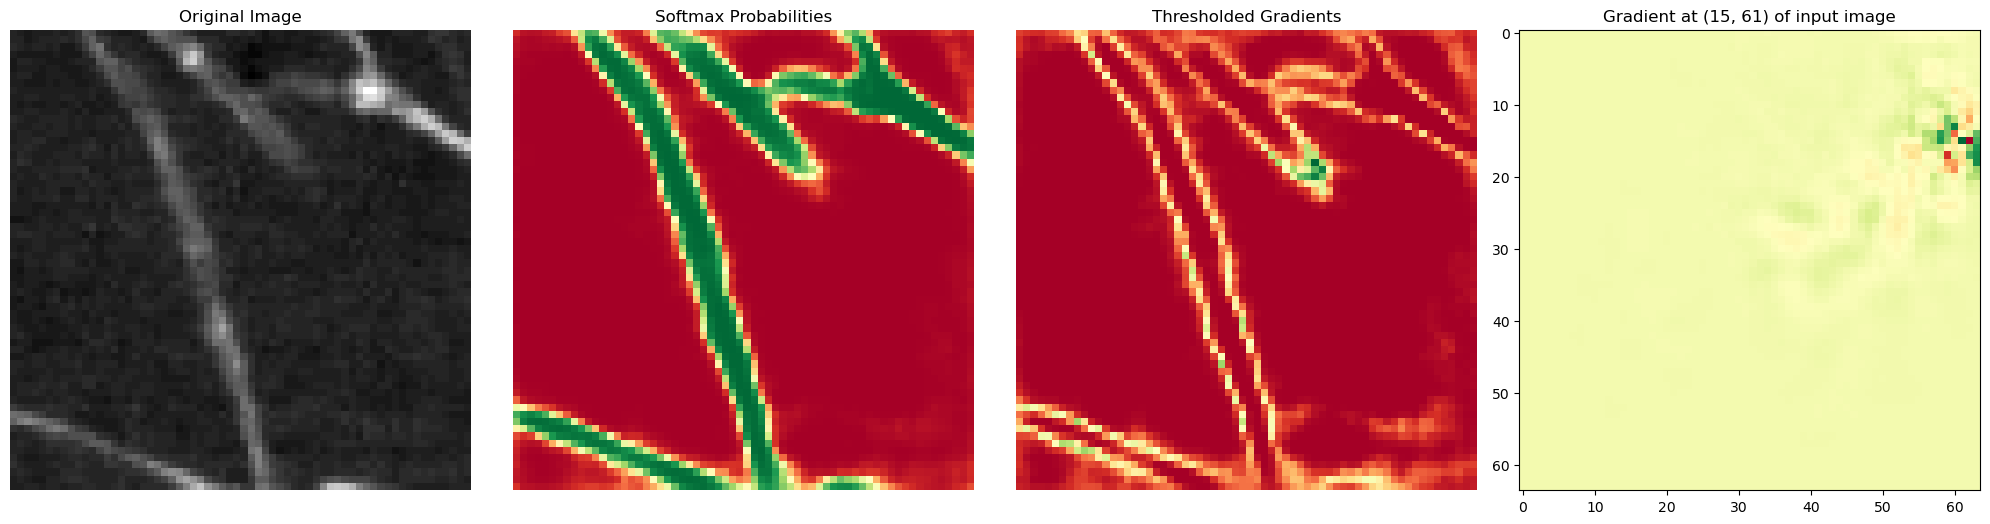

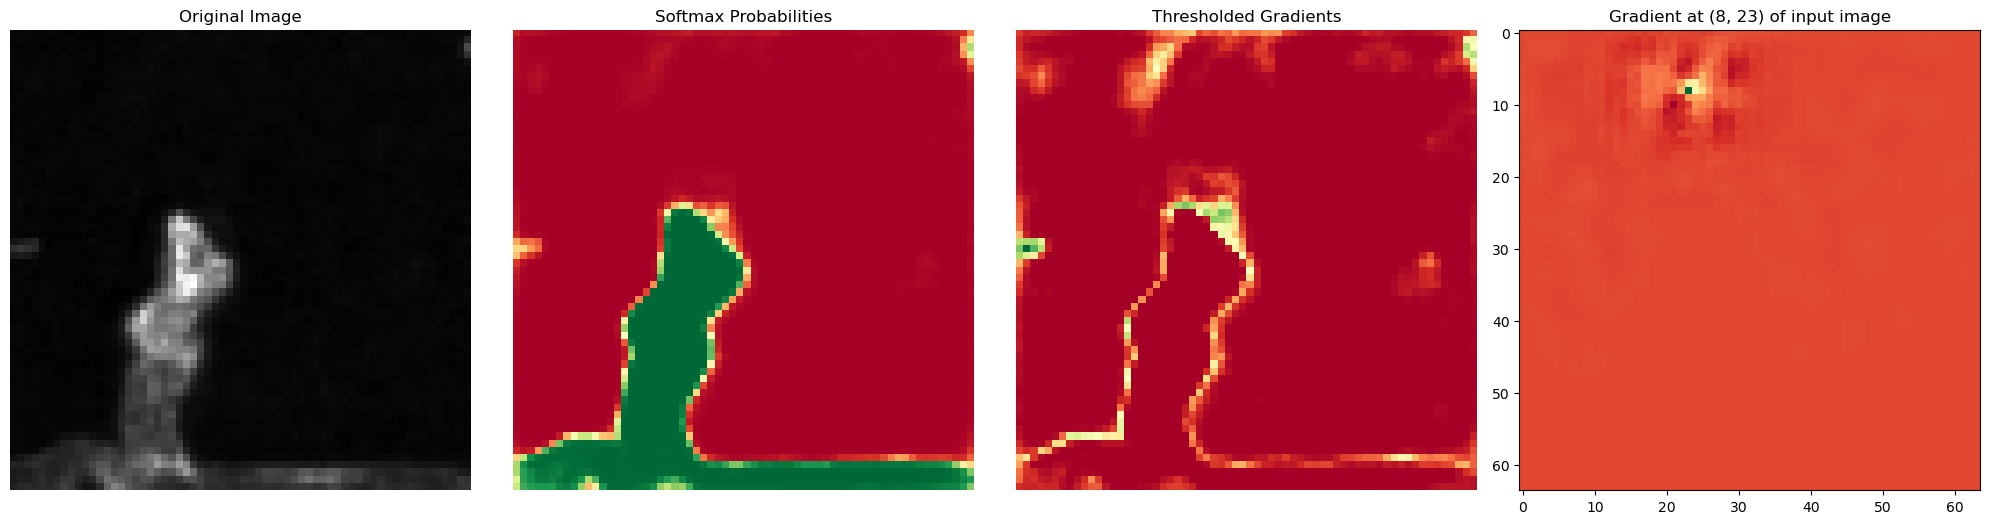

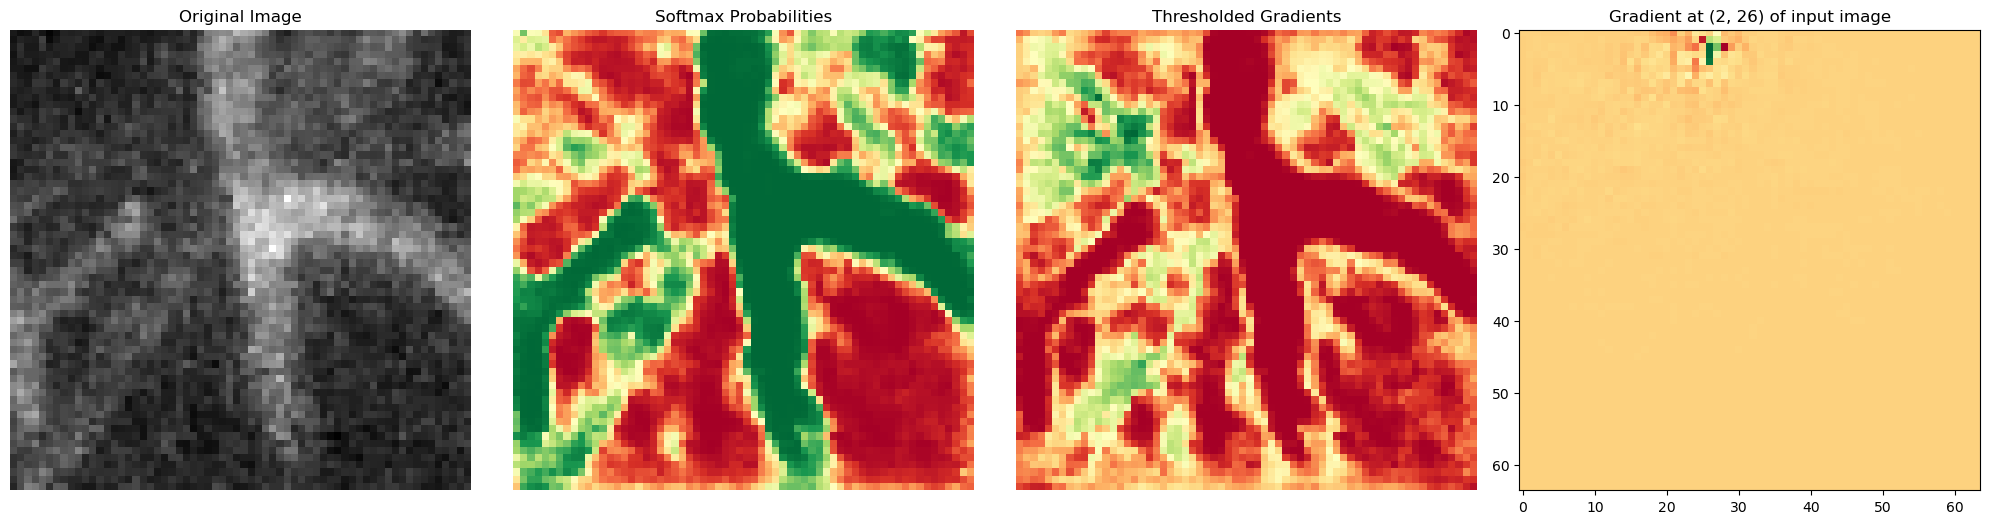

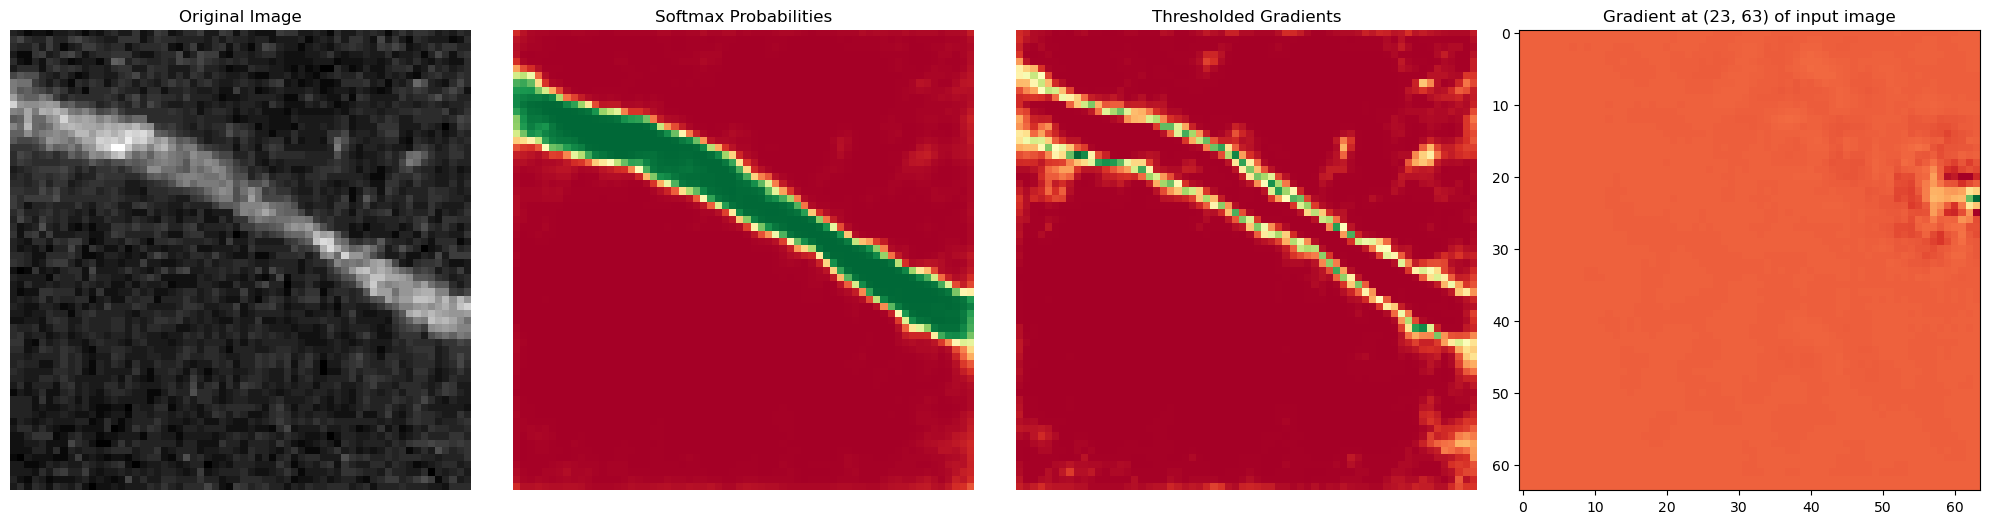

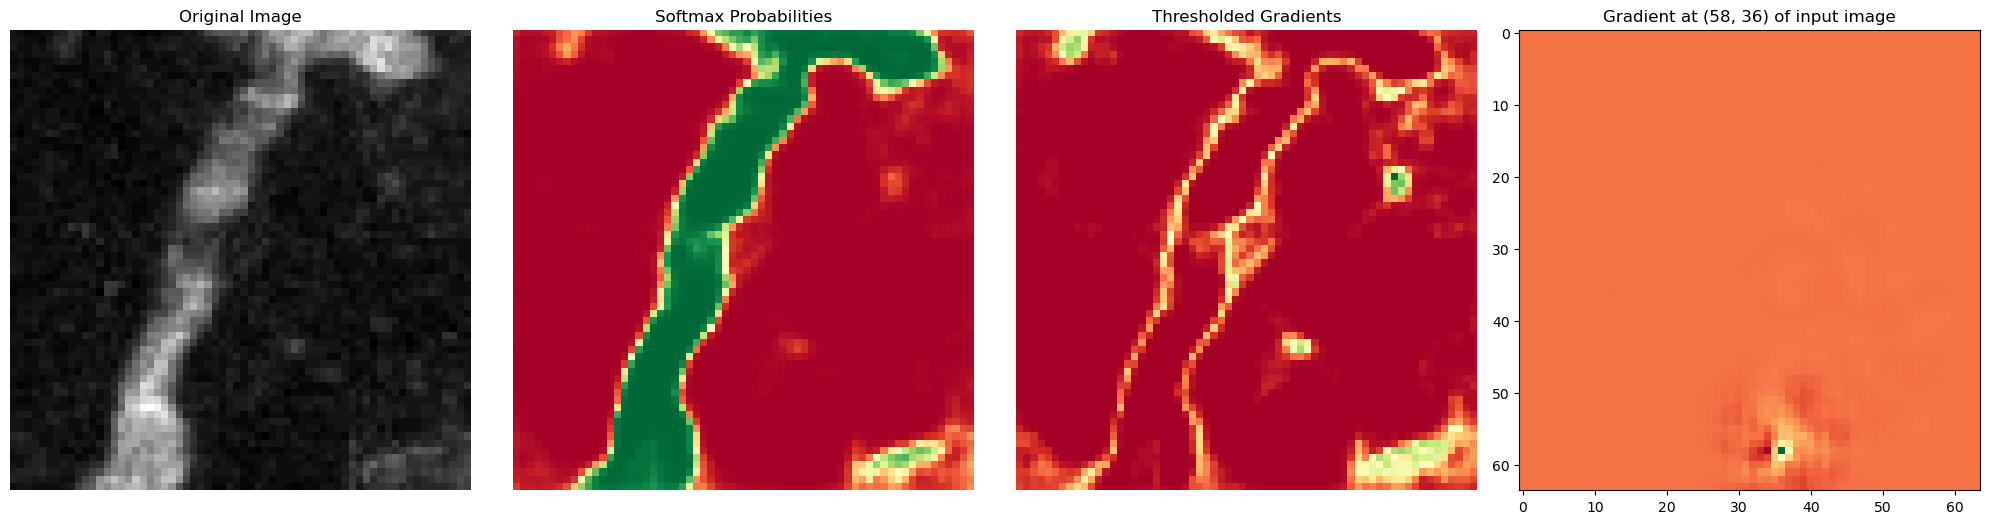

In [22]:
# Loop to visualize multiple images and their thresholded gradients
for idx in range(5):
    if idx == 9:
        idx = '09'
    
    # Gradient tensor loaded from a file
    gradient_tensor = torch.load(f'./gradients/jacobian_gradient_{idx}.pt')
    coordinate = (np.random.randint(0, 65), np.random.randint(0, 65))  # Random test coordinate

    # Load thresholded gradient image
    thresholded_image = np.load(f'./thresholded_gradients/image_{idx}.npy')
    
    # Get original image and model output
    original_image = original_images[idx].cpu().numpy()
    model_mask = model(original_images[idx].unsqueeze(0).unsqueeze(0))
    softmax_probs = F.softmax(model_mask, dim=1)
    class_one_probs = softmax_probs[0, 1, :, :].detach().cpu().numpy()

    # Visualize the results with the updated function
    visualize_thresholded_gradients(original_image, class_one_probs, thresholded_image, gradient_tensor, coordinate)